<a href="https://colab.research.google.com/github/chandrusuresh/ReinforcementLearning/blob/master/Ch10-OnPolicyControlwithApproximation/MountainCar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm.auto import trange
%matplotlib inline

## Tile Coding

In [2]:
"""
Tile Coding Software version 3.0beta
by Rich Sutton
based on a program created by Steph Schaeffer and others
External documentation and recommendations on the use of this code is available in the 
reinforcement learning textbook by Sutton and Barto, and on the web.
These need to be understood before this code is.

This software is for Python 3 or more.

This is an implementation of grid-style tile codings, based originally on
the UNH CMAC code (see http://www.ece.unh.edu/robots/cmac.htm), but by now highly changed. 
Here we provide a function, "tiles", that maps floating and integer
variables to a list of tiles, and a second function "tiles-wrap" that does the same while
wrapping some floats to provided widths (the lower wrap value is always 0).

The float variables will be gridded at unit intervals, so generalization
will be by approximately 1 in each direction, and any scaling will have 
to be done externally before calling tiles.

Num-tilings should be a power of 2, e.g., 16. To make the offsetting work properly, it should
also be greater than or equal to four times the number of floats.

The first argument is either an index hash table of a given size (created by (make-iht size)), 
an integer "size" (range of the indices from 0), or nil (for testing, indicating that the tile 
coordinates are to be returned without being converted to indices).
"""

basehash = hash

class IHT:
  "Structure to handle collisions"
  def __init__(self, sizeval):
      self.size = sizeval                        
      self.overfullCount = 0
      self.dictionary = {}

  def __str__(self):
      "Prepares a string for printing whenever this object is printed"
      return "Collision table:" + \
              " size:" + str(self.size) + \
              " overfullCount:" + str(self.overfullCount) + \
              " dictionary:" + str(len(self.dictionary)) + " items"

  def count (self):
      return len(self.dictionary)
  
  def fullp (self):
      return len(self.dictionary) >= self.size
  
  def getindex (self, obj, readonly=False):
      d = self.dictionary
      if obj in d: return d[obj]
      elif readonly: return None
      size = self.size
      count = self.count()
      if count >= size:
          if self.overfullCount==0: print('IHT full, starting to allow collisions')
          self.overfullCount += 1
          return basehash(obj) % self.size
      else:
          d[obj] = count
          return count

def hashcoords(coordinates, m, readonly=False):
  if type(m)==IHT: return m.getindex(tuple(coordinates), readonly)
  if type(m)==int: return basehash(tuple(coordinates)) % m
  if m==None: return coordinates

from math import floor, log
from itertools import zip_longest

def tiles (ihtORsize, numtilings, floats, ints=[], readonly=False):
  """returns num-tilings tile indices corresponding to the floats and ints"""
  qfloats = [floor(f*numtilings) for f in floats]
  Tiles = []
  for tiling in range(numtilings):
      tilingX2 = tiling*2
      coords = [tiling]
      b = tiling
      for q in qfloats:
          coords.append( (q + b) // numtilings )
          b += tilingX2
      coords.extend(ints)
      Tiles.append(hashcoords(coords, ihtORsize, readonly))
  return Tiles

## Mountain Car

In [3]:
maxSize = 4096
iht = IHT(maxSize)
numTilings = 8

# weights = np.random.uniform(0,1,(maxSize,))#[0]*maxSize
numTilings = 8
stepSize = 0.3/float(numTilings)

xLim = [-1.2,0.5]
yLim = [-0.07,0.07]

actions = [-1,0,1]
nA = len(actions)

In [4]:
def mytiles(s,a):
  x = s[0]
  y = s[1]
  scaleFactor_x = float(numTilings)/(xLim[1]-xLim[0])
  scaleFactor_y = float(numTilings)/(yLim[1]-yLim[0])
  return tiles(iht, numTilings, [x*scaleFactor_x,y*scaleFactor_y],[a])

def move(pos,action):
  new_pos = list(pos)
  new_pos[1] += 0.001*action - 0.0025*np.cos(3*pos[0])
  new_pos[1] = max(yLim[0],min(yLim[1],new_pos[1]))

  new_pos[0] += new_pos[1]
  new_pos[0] = max(xLim[0],min(xLim[1],new_pos[0]))

  if new_pos[0] == xLim[0]:
    new_pos[1] = 0
  return new_pos

def getActionValue(s,a,wt):
  tile_idx = mytiles(s,a)
  return np.sum(wt[tile_idx])

def target_policy(s,wt,epsilon):
  Q = np.zeros((nA,))
  for i,a in enumerate(actions):
    Q[i] = getActionValue(s,a,wt)
  action_prob = epsilon/float(nA)*np.ones((nA,))
  maxQ = np.max(Q)
  idx = np.where(Q == maxQ)[0]
  action_prob[idx] += (1-epsilon)/float(len(idx))
  # print('Q = ',Q)
  # print('Max Q = ',maxQ)
  # print('Max Q idx = ',idx)
  # print('Action_prob = ',action_prob)
  return np.random.choice(range(nA),p=action_prob)

def episodic_semigradient_sarsa(numRuns,num_episodes,alpha,gamma,epsilon,saveWeights=False):
  weights = np.zeros((maxSize,))
  steps = 0
  step_start = 0
  stats = []
  step_stats = np.zeros((num_episodes,1))
  for run in trange(numRuns, desc='Runs'):#tqdm(range(numRuns)):
    for episode in trange(num_episodes,desc="Episodes",disable=numRuns>1):#tqdm(range(num_episodes)):
      pos = [0,0]
      pos[0] = np.random.uniform(-0.6,-0.4)
      act_idx = target_policy(pos,weights,epsilon)
      while pos[0] < xLim[1]:
        steps+=1
        next_pos = move(pos,actions[act_idx])
        tile_idx = mytiles(pos,actions[act_idx])
        Q_curr = getActionValue(pos,actions[act_idx],weights)
        if next_pos[0] >= xLim[1]:
          reward = 0
          delta = alpha*(reward - Q_curr) 
          weights[tile_idx] += delta
          step_stats[episode,0] += (steps-step_start)/numRuns
          step_start = steps
          # print('Steps to complete episode:',episode,step_stats[episode])
          break;
        next_act_idx = target_policy(next_pos,weights,epsilon)
        Q_next = getActionValue(next_pos,actions[next_act_idx],weights)
        # if steps%100 == 0:
        #   print("Q values:",steps,Q_curr,Q_next)
        delta = alpha*(-1+gamma*Q_next-Q_curr)
        weights[tile_idx] += delta

        pos = next_pos.copy()
        act_idx = next_act_idx
        if steps == 427 and saveWeights:
          stats += [np.copy(weights)]
      if episode in [11,103,999] and saveWeights:
        stats += [np.copy(weights)]
    if saveWeights:
      stats += [np.copy(weights)]
  return stats,step_stats

In [5]:
gamma = 1.0
epsilon = 0.0
num_episodes = 9000
numRuns = 1
np.random.seed(42)
stats,step_stats = episodic_semigradient_sarsa(numRuns,num_episodes,stepSize,gamma,epsilon,True)

In [6]:
pos = np.linspace(xLim[0],xLim[1],50)
vel = np.linspace(yLim[0],yLim[1],50)
costToGo = []

for wt in stats:
  neg_maxQ = np.zeros((len(pos),len(vel)))
  for i,p in enumerate(pos):
    for j,v in enumerate(vel):
      s = [p,v]
      Q = np.zeros((nA,))
      for k,a in enumerate(actions):
        Q[k] = getActionValue(s,a,wt)
      neg_maxQ[i,j] = -np.max(Q)
  costToGo += [neg_maxQ]

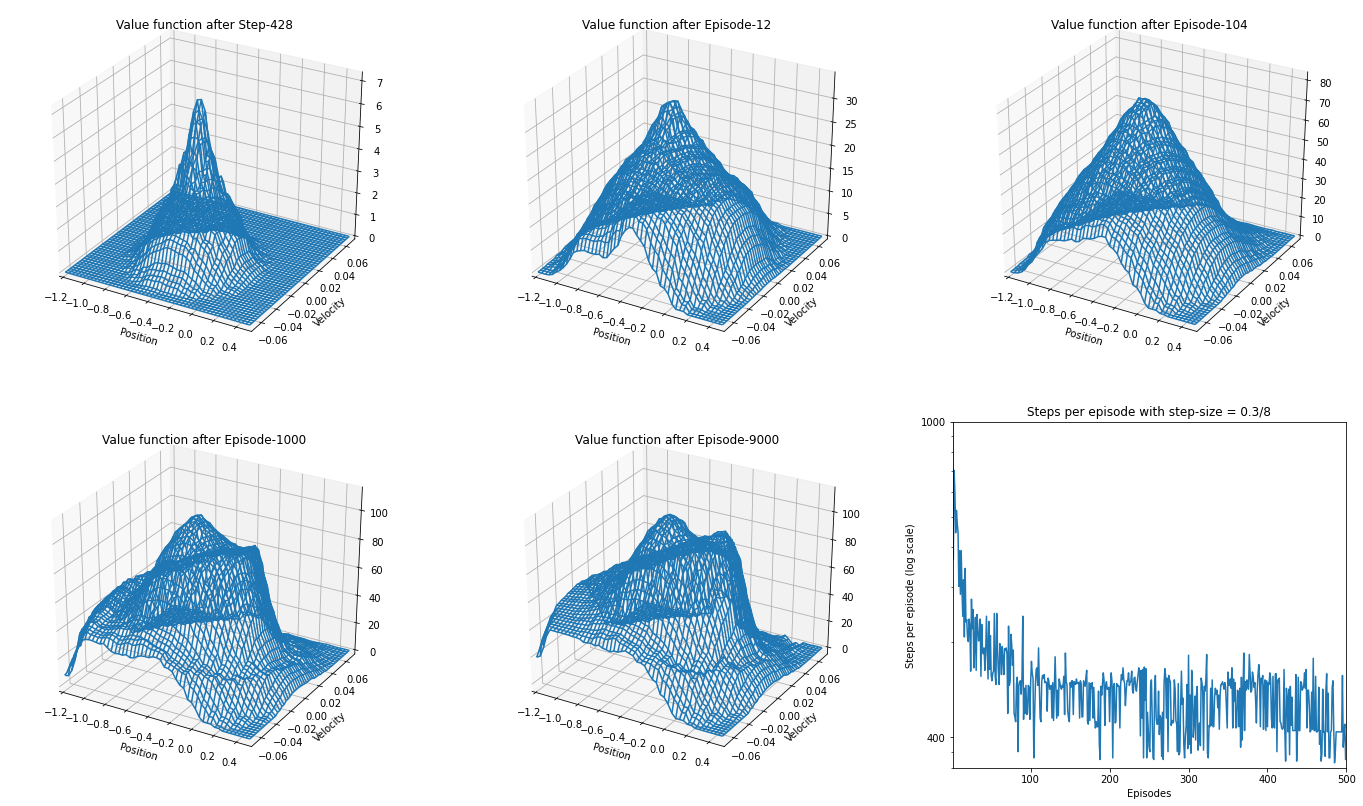

In [7]:
X,Y = np.meshgrid(pos,vel)
fig = plt.figure(figsize=(24,14))
title = ['Step-428','Episode-12','Episode-104','Episode-1000','Episode-9000']
for i,neg_maxQ in enumerate(costToGo):
  ax = fig.add_subplot(2, 3, i+1, projection='3d')
  ax.set_title('Value function after ' + title[i])
  ax.plot_wireframe(X, Y, neg_maxQ)#, rstride=10, cstride=10)
  ax.view_init(elev=30., azim=-60)
  ax.set_xlim([xLim[0],xLim[1]])
  ax.set_ylim([yLim[0],yLim[1]])
  ax.set_xlabel('Position')
  ax.set_ylabel('Velocity')

ax = fig.add_subplot(2,3,6)
ax.plot(range(1,num_episodes),step_stats[1:]);
ax.set_title('Steps per episode with step-size = 0.3/8')
ax.set_ylabel('Steps per episode (log scale)')
ax.set_xlabel('Episodes')
ax.set_yscale('log')
ax.set_yticklabels([100,200,400,1000])
ax.set_ylim([80,1000]);
ax.set_xlim([1,500]);

In [8]:
gamma = 1.0
epsilon = 0.0
num_episodes = 500
numRuns = 10
step_size = [0.1/8,0.2/8,0.5/8]
step_stats = np.zeros((num_episodes,len(step_size)))
for i in trange(len(step_size),desc='Step Size'):
  alpha = step_size[i]
  np.random.seed(42)
  _,steps = episodic_semigradient_sarsa(numRuns,num_episodes,alpha,gamma,epsilon)
  step_stats[:,i] = steps.reshape((step_stats[:,i].shape))


(500, 1)



(500, 1)



(500, 1)



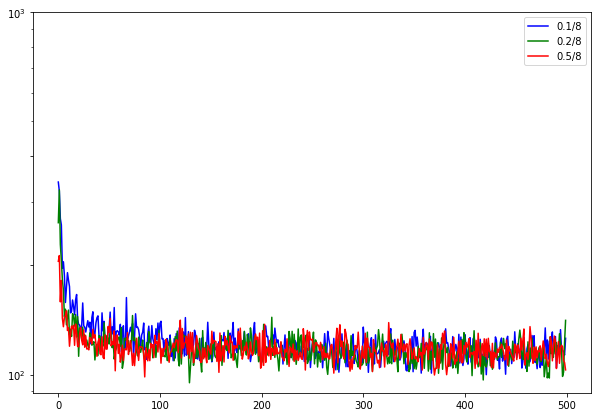

In [12]:
fig,ax = plt.subplots(1,1,figsize=(10,7))
legend = ['0.1/8','0.2/8','0.5/8']
color = ['b','g','r']
for i,s in enumerate(step_size):
  ax.plot(range(num_episodes),step_stats[:,i],color[i])
ax.set_yscale('log')
ax.set_yticks([100,200,400,1000])
ax.legend(legend)

In [9]:
# def episodic_semigradient_nStep_sarsa(numRuns,num_episodes,numSteps,alpha,gamma,epsilon,saveWeights=False):
#   weights = np.zeros((maxSize,))
#   steps = 0
#   step_start = 0
#   stats = []
#   step_stats = np.zeros((num_episodes,1))
#   for run in trange(numRuns, desc='Runs'):#tqdm(range(numRuns)):
#     for episode in trange(num_episodes,desc="Episodes",disable=numRuns>1):#tqdm(range(num_episodes)):
#       pos = [0,0]
#       pos[0] = np.random.uniform(-0.6,-0.4)
#       act_idx = target_policy(pos,weights,epsilon)
#       hx_traj = []
#       hx_Q = []
#       hx_tiles = []
#       while pos[0] < xLim[1]:
#         steps+=1
#         next_pos = move(pos,actions[act_idx])
#         tile_idx = mytiles(pos,actions[act_idx])
#         Q_curr = getActionValue(pos,actions[act_idx],weights)
#         hx_traj += [pos+[act_idx]]
#         hx_Q += [Q_curr]
#         hx_tiles += [tile_idx]
#         if len(hx_traj) >= numSteps:

#           continue
#         if next_pos[0] >= xLim[1]:
#           reward = 0
#           delta = alpha*(reward - Q_curr) 
#           weights[tile_idx] += delta
#           step_stats[episode,0] += (steps-step_start)/numRuns
#           step_start = steps
#           # print('Steps to complete episode:',episode,step_stats[episode])
#           break;
#         next_act_idx = target_policy(next_pos,weights,epsilon)
#         Q_next = getActionValue(next_pos,actions[next_act_idx],weights)
#         # if steps%100 == 0:
#         #   print("Q values:",steps,Q_curr,Q_next)
#         delta = alpha*(-1+gamma*Q_next-Q_curr)
#         weights[tile_idx] += delta

#         pos = next_pos.copy()
#         act_idx = next_act_idx
#         if steps == 427 and saveWeights:
#           stats += [np.copy(weights)]
#       if episode in [11,103,999] and saveWeights:
#         stats += [np.copy(weights)]
#     if saveWeights:
#       stats += [np.copy(weights)]
#   return stats,step_stats